Test different methods of correcting for spatial autocorrelation inherit in brain maps.

In [1]:
%load_ext autoreload
%autoreload 2

In [18]:
from pathlib import Path
import mne
import mni_utils as uti
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr

Import some test data:

In [6]:
df_x = pd.read_csv(
    "F:\iEEG_neural_dynamics\MNIOpen\df_structural_avg.csv", index_col=0
)["T1T2"]
df_y = pd.read_csv(
    "F:\iEEG_neural_dynamics\MNIOpen\Results_psd_exp\exp_parc_W.csv", index_col=0
).squeeze()

Import parcellation and find centroids

In [24]:
subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
surface_name = "HCPMMP1"
labels = mne.read_labels_from_annot(
    "fsaverage", surface_name, "both", subjects_dir=subjects_dir, surf_name="sphere"
)

Reading labels from parcellation...
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.HCPMMP1.annot
   read 181 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\rh.HCPMMP1.annot


In [26]:
labels

[<Label | fsaverage, '???-lh', lh : 13868 vertices>,
 <Label | fsaverage, '???-rh', rh : 13940 vertices>,
 <Label | fsaverage, 'L_10d_ROI-lh', lh : 867 vertices>,
 <Label | fsaverage, 'L_10pp_ROI-lh', lh : 401 vertices>,
 <Label | fsaverage, 'L_10r_ROI-lh', lh : 445 vertices>,
 <Label | fsaverage, 'L_10v_ROI-lh', lh : 694 vertices>,
 <Label | fsaverage, 'L_11l_ROI-lh', lh : 713 vertices>,
 <Label | fsaverage, 'L_13l_ROI-lh', lh : 791 vertices>,
 <Label | fsaverage, 'L_1_ROI-lh', lh : 2162 vertices>,
 <Label | fsaverage, 'L_23c_ROI-lh', lh : 1253 vertices>,
 <Label | fsaverage, 'L_23d_ROI-lh', lh : 511 vertices>,
 <Label | fsaverage, 'L_24dd_ROI-lh', lh : 1115 vertices>,
 <Label | fsaverage, 'L_24dv_ROI-lh', lh : 677 vertices>,
 <Label | fsaverage, 'L_25_ROI-lh', lh : 369 vertices>,
 <Label | fsaverage, 'L_2_ROI-lh', lh : 2554 vertices>,
 <Label | fsaverage, 'L_31a_ROI-lh', lh : 346 vertices>,
 <Label | fsaverage, 'L_31pd_ROI-lh', lh : 545 vertices>,
 <Label | fsaverage, 'L_31pv_ROI-lh'

In [31]:
index_df = [i + "_lh" for i in df_x.index] + [i + "_rh" for i in df_x.index]
sphere_mmp = pd.DataFrame(columns=["x", "y", "z"], index=index_df)
for label in labels[2:]:
    parcel_name = label.name[2:-7] + "_" + label.hemi
    sphere_mmp.loc[parcel_name] = label.pos.mean(axis=0) * 1000  # mm
sphere_mmp = sphere_mmp.astype(float)

In [257]:
sphere_mmp

,x,y,z
V1_lh,36.903210,-69.672657,-55.425578
MST_lh,-55.942361,-70.713167,-42.323695
V6_lh,48.466582,-85.774597,-12.411513
V2_lh,30.264767,-70.008611,-53.233070
V3_lh,11.935245,-76.895974,-49.698245
...,...,...,...
STSva_rh,55.985172,-0.590655,-82.054241
TE1m_rh,40.742973,-20.232973,-88.505900
PI_rh,57.779810,47.675649,-65.014161
a32pr_rh,-68.230166,57.599668,43.609701


In [258]:
sphere_mmp.to_csv("F:\iEEG_neural_dynamics\MNIOpen\mmp_centroids_coords.csv")

### Method "vasa"

Generate null maps for x:

In [55]:
nspins = 10000
hemiid = np.array([0] * len(df_x.index) + [1] * len(df_x.index))
spins = uti.gen_spinsamples(sphere_mmp, hemiid, nspins, method="vasa")

In [56]:
spins.shape

(360, 10000)

In [57]:
df_xx = pd.concat([df_x, df_x])
df_yy = pd.concat([df_y, df_y])

In [58]:
corrtype = "spearman"
corrval = spearmanr(df_x, df_y)[0]
permuted_xy = np.zeros(nspins)
permuted_yx = np.zeros(nspins)
for spin in range(nspins):
    if corrtype == "spearman":
        permuted_xy[spin] = spearmanr(df_xx[spins[:, spin]], df_yy)[0]
        permuted_yx[spin] = spearmanr(df_yy[spins[:, spin]], df_xx)[0]
    elif corrtype == "pearson":
        permuted_xy[spin] = pearsonr(df_xx[spins[:, spin]], df_yy)[0]
        permuted_yx[spin] = pearsonr(df_yy[spins[:, spin]], df_xx)[0]

C:\Users\ricca\AppData\Local\Temp\ipykernel_19020\455341480.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  permuted_xy[spin] = spearmanr(df_xx[spins[:, spin]], df_yy)[0]
C:\Users\ricca\AppData\Local\Temp\ipykernel_19020\455341480.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  permuted_yx[spin] = spearmanr(df_yy[spins[:, spin]], df_xx)[0]


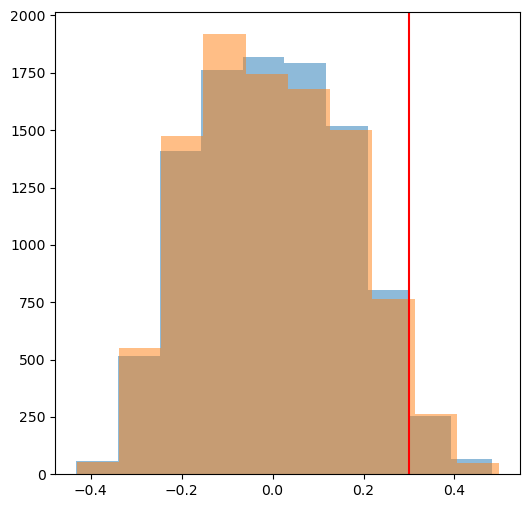

In [59]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.hist(permuted_xy, alpha=0.5, label="permuted_xy")
plt.hist(permuted_yx, alpha=0.5, label="permuted_yx")
plt.axvline(corrval, color="red", label="corrval")
plt.show()

Approach of Vasa to calculate the p-value:
- average of the two null maps (obtained by permuting x or y)
- it is one-sided -> not good , keep it two-sided

In [60]:
if corrval > 0:
    p_xy = (permuted_xy > corrval).mean()
    p_yx = (permuted_yx > corrval).mean()
else:
    p_xy = (permuted_xy < corrval).mean()
    p_yx = (permuted_yx < corrval).mean()
p_corr = (p_xy + p_yx) / 2
p_corr

0.0344

Approach in Shaifei et al. (2023)

In [62]:
permmean = np.mean(permuted_xy)
pvalspin = (
    len(np.where(abs(permuted_xy - permmean) >= abs(corrval - permmean))[0]) + 1
) / (nspins + 1)
pvalspin

0.050994900509949

"Normal" approach (just take values smaller than the null maps):

In [61]:
(abs(permuted_xy - permmean) > abs(corrval - permmean)).mean()

0.0494

### Method "original" (Alexander-Bloch et al.)

Generate null maps for x:

In [63]:
nspins = 10000
hemiid = np.array([0] * len(df_x.index) + [1] * len(df_x.index))
spins = uti.gen_spinsamples(sphere_mmp, hemiid, nspins, method="original")

In [64]:
df_xx = pd.concat([df_x, df_x])
df_yy = pd.concat([df_y, df_y])

In [66]:
corrtype = "spearman"
corrval = spearmanr(df_x, df_y)[0]
permuted_p = np.zeros(nspins)
for spin in range(nspins):
    if corrtype == "spearman":
        permuted_p[spin] = spearmanr(df_xx[spins[:, spin]], df_yy)[0]
    elif corrtype == "pearson":
        permuted_p[spin] = pearsonr(df_xx[spins[:, spin]], df_yy)[0]

C:\Users\ricca\AppData\Local\Temp\ipykernel_19020\499320456.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  permuted_p[spin] = spearmanr(df_xx[spins[:, spin]], df_yy)[0]


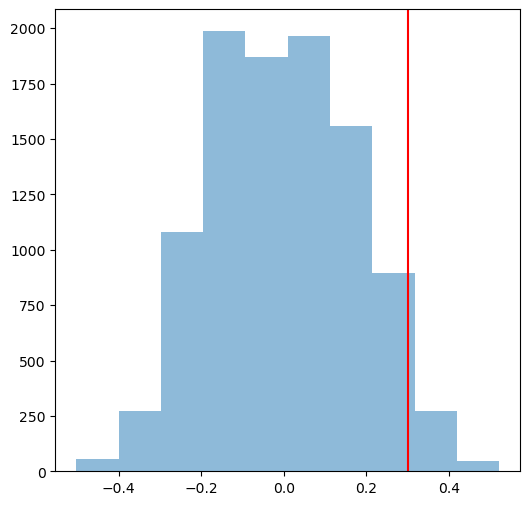

In [68]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.hist(permuted_p, alpha=0.5, label="permuted")
plt.axvline(corrval, color="red", label="corrval")
plt.show()

"Normal" approach (just take values smaller than the null maps):

In [69]:
(abs(permuted_xy - permmean) > abs(corrval - permmean)).mean()

0.0743

## Check technique on MNI Atlas

First import Destrieux labels and MNI<->Destrieux conversion:

In [114]:
df_mnia_dest = pd.read_excel(
    "F:\iEEG_neural_dynamics\MNIOpen\mnia_Destrieux_labels.xlsx", index_col=0
)
df_mnia_dest["Destrieux atlas name"] = df_mnia_dest["Destrieux atlas name"].str.strip("'")
df_mnia_dest.rename(columns={
    "Destrieux atlas name": "Destrieux",
    "MNIA equivalent": "MNIA",
}, inplace=True)
df_mnia_dest.drop(columns="Expanded name", inplace=True)

subjects_dir = str(mne.datasets.sample.data_path()) + "/subjects"
surface_name = "aparc.a2009s"

labels_dest_lh = mne.read_labels_from_annot(
    "fsaverage", surface_name, "lh", subjects_dir=subjects_dir, surf_name="sphere"
)
labels_dest_rh = mne.read_labels_from_annot(
    "fsaverage", surface_name, "rh", subjects_dir=subjects_dir, surf_name="sphere"
)
labels_dest = {"lh": labels_dest_lh, "rh": labels_dest_rh}

Reading labels from parcellation...
   read 75 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\lh.aparc.a2009s.annot
Reading labels from parcellation...
   read 75 labels from C:\Users\ricca\mne_data\MNE-sample-data\subjects\fsaverage\label\rh.aparc.a2009s.annot


In [97]:
df_mnia_dest

,Destrieux,MNIA
1.0,G_and_S_frontomargin,Superior frontal gyrus and frontal pole
2.0,G_and_S_occipital_inf,Inferior ocipital gyrus and occipital pole
3.0,G_and_S_paracentral,Postcentral gyrus (including medial segment)
4.0,G_and_S_subcentral,Central operculum
5.0,G_and_S_transv_frontopol,Superior frontal gyrus and frontal pole
...,...,...
NaN,NaN,Hippocampus
16.0,G_front_sup,Medial segment of precentral gyrus
16.0,G_front_sup,Medial segment of superior frontal gyrus
16.0,G_front_sup,Medial frontal cortex


In [102]:
labels_dest_lh[0] + labels_dest_lh[1]

<Label | fsaverage, 'G_Ins_lg_and_S_cent_ins-lh + G_and_S_cingul-Ant-lh', lh : 2940 vertices>

In [103]:
df_mnia_dest[df_mnia_dest["Destrieux"] == labels_dest_lh[0].name[:-3]]

,Destrieux,MNIA
17.0,G_Ins_lg_and_S_cent_ins,Posterior insula


Problem: how to account for Amygdala and Hippocampus?
1. assume they are different structures, not related to the cortex, so we don't need to take them into account when generating nulls.
2. project them to the cortex --> how??

### Approach 1
We permute all the cortical parcels extracted from the Destrieux atlas, after merging them together to reflect the MNI atlas. Then, we append the data for hippocampus and amygdala (non permuted) to the permuted data. This approach seems on the conservative side, since we preserve the relation of the two parcels we don't permute with the rest of the cortex.

In [122]:
df_mnia_dest.dropna()["MNIA"]

1.0          Superior frontal gyrus and frontal pole
2.0       Inferior ocipital gyrus and occipital pole
3.0     Postcentral gyrus (including medial segment)
4.0                                Central operculum
5.0          Superior frontal gyrus and frontal pole
                            ...                     
74.0                         Superior temporal gyrus
16.0              Medial segment of precentral gyrus
16.0        Medial segment of superior frontal gyrus
16.0                           Medial frontal cortex
16.0                      Supplementary motor cortex
Name: MNIA, Length: 78, dtype: object

In [180]:
coords_mnia = {"lh": [], "rh": []}
for reg in df_mnia_dest.dropna()["MNIA"].unique():
    df_mnia_dest_reg = df_mnia_dest[df_mnia_dest["MNIA"] == reg]
    labels_destr_reg = df_mnia_dest_reg["Destrieux"].to_list()
    for hemi in ["lh", "rh"]:
        labels_reg_hemi = [
            label for label in labels_dest[hemi] if label.name[:-3] in labels_destr_reg
        ]
        labels_reg_hemi_concat = labels_reg_hemi[0].copy()
        for label in labels_reg_hemi[1:]:
            labels_reg_hemi_concat += label
        # Get coordinates
        labels_reg_hemi_concat_coords = labels_reg_hemi_concat.pos.mean(axis=0) * 1000  # mm
        coords_mnia[hemi].append(labels_reg_hemi_concat_coords)
        

In [181]:
coords_mnia["lh"] = np.array(coords_mnia["lh"])
coords_mnia["rh"] = np.array(coords_mnia["rh"])

In [182]:
labels_mnia_all = np.concatenate([coords_mnia["lh"], coords_mnia["rh"]])
labels_mnia_all.shape

(72, 3)

In [261]:
idx = [i + "_lh" for i in df_mnia_dest.dropna()["MNIA"].unique()] + [i + "_rh" for i in df_mnia_dest.dropna()["MNIA"].unique()]
pd.DataFrame(labels_mnia_all, columns=["x", "y", "z"], index=idx).to_csv("F:\iEEG_neural_dynamics\MNIOpen\mnia_centroids_coords.csv")

Sample data to test:

In [233]:
# Dataframe with the fit parameters on each MNI region
df_sc_params_mni = pd.read_csv("F:/iEEG_neural_dynamics/MNIOpen/Results_SC/SC_R_fit_mni_regs.csv", index_col=0)

# Dataframe with timescales for all electrodes
df_tau = pd.read_csv("F:/iEEG_neural_dynamics/MNIOpen/Results/all_tau.csv", index_col=0)
df_tau_mni = uti.get_avg_tau_mni(df_tau[df_tau["stage"] == "R"].copy())
df_tau_mni = df_tau_mni.loc[df_sc_params_mni.index]

In [234]:
# Separate cortical and amygdala/hippocampus regions
df_tau_mni_ctx = df_tau_mni.drop(["Amygdala", "Hippocampus"])
df_tau_mni_ha = df_tau_mni.loc[["Amygdala", "Hippocampus"]]
df_sc_params_mni_ctx = df_sc_params_mni.drop(["Amygdala", "Hippocampus"])
df_sc_params_mni_ha = df_sc_params_mni.loc[["Amygdala", "Hippocampus"]]
np.array_equal(df_tau_mni_ctx.index, df_sc_params_mni_ctx.index)

True

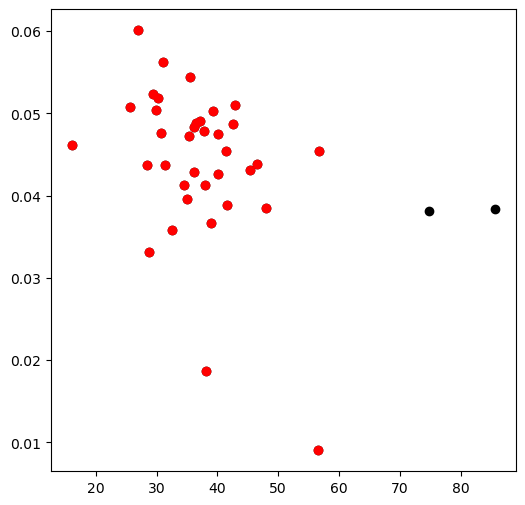

In [235]:
plt.figure(figsize=(6, 6))
plt.plot(df_tau_mni, df_sc_params_mni["b"], "ko")
plt.plot(df_tau_mni_ctx, df_sc_params_mni_ctx["b"], "ro")
plt.show()

Generate null maps for x:

In [249]:
nspins = 1000
hemiid = np.array([0] * len(df_tau_mni_ctx) + [1] * len(df_tau_mni_ctx))
spins = uti.gen_spinsamples(labels_mnia_all, hemiid, nspins, method="vasa")
spins.shape

(72, 1000)

In [250]:
df_xx = pd.concat([df_tau_mni_ctx, df_tau_mni_ctx])
df_yy = pd.concat([df_sc_params_mni_ctx, df_sc_params_mni_ctx])

In [254]:
corrtype = "spearman"

if corrtype == "spearman":
    corrval = spearmanr(df_tau_mni, df_sc_params_mni["b"])[0]
    corrval_ctx = spearmanr(df_tau_mni_ctx, df_sc_params_mni_ctx["b"])[0]
    print(corrval, corrval_ctx)
elif corrtype == "pearson":
    corrval = pearsonr(df_tau_mni, df_sc_params_mni["b"])[0]
    corrval_ctx = pearsonr(df_tau_mni_ctx, df_sc_params_mni_ctx["b"])[0]
    print(corrval, corrval_ctx)

permuted_p = np.zeros(nspins)
for spin in range(nspins):
    x_perm = df_xx[spins[:, spin]].to_list() + df_tau_mni_ha.to_list() * 2
    y_perm = df_yy["b"].to_list() + df_sc_params_mni_ha["b"].to_list() * 2
    if corrtype == "spearman":
        permuted_p[spin] = spearmanr(x_perm, y_perm)[0]
    elif corrtype == "pearson":
        permuted_p[spin] = pearsonr(x_perm, y_perm)[0]

-0.39271255060728744 -0.33153153153153153


C:\Users\ricca\AppData\Local\Temp\ipykernel_19020\1211802650.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x_perm = df_xx[spins[:, spin]].to_list() + df_tau_mni_ha.to_list() * 2


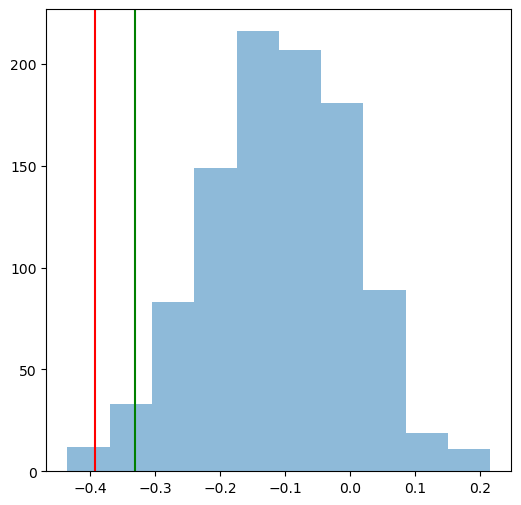

In [255]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.hist(permuted_p, alpha=0.5, label="permuted")
plt.axvline(corrval, color="red", label="corrval")
plt.axvline(corrval_ctx, color="g", label="corrval")
plt.show()

"Normal" approach (just take values smaller than the null maps):

In [256]:
permmean = np.mean(permuted_p)
print((abs(permuted_p - permmean) > abs(corrval - permmean)).mean())
# print((abs(permuted_p - permmean) > abs(corrval_ctx - permmean)).mean())

0.019
